In [1]:
#import dependents
import pandas as pd
pd.set_option('max_columns', None)
pd.set_option('max_rows', None)
pd.set_option('max_colwidth', None)
pd.options.display.float_format = '{:,.3f}'.format
pd.get_option("display.max_columns")
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [10, 6]
from lmfit import Minimizer, Parameters, report_fit
import warnings
warnings.filterwarnings('ignore')
import datetime

In [2]:
#data cleaning
def cleanDF(df):
    df = df.drop(df[(df.year == 2020) & (df.quarter == 2)].index)
    df = df.drop(df[(df.year == 2020) & (df.quarter == 3)].index)
    df.index = range(0,len(df))
    #creat Vs
    df.rename(columns = {'Duration of job vacancy, all durations': 'all'}, inplace = True)
    df.rename(columns = {'Less than 15 days': 'a000b014'}, inplace = True)
    df.rename(columns = {'15 to 29 days': 'a015b029'}, inplace = True)
    df.rename(columns = {'30 to 59 days': 'a030b059'}, inplace = True)
    df.rename(columns = {'60 to 89 days': 'a060b089'}, inplace = True)
    df.rename(columns = {'90 days or more': 'a090binf'}, inplace = True)
    df.rename(columns = {'90 to 119 days': 'a090b119'}, inplace = True)
    df.rename(columns = {'120 days or more': 'a120binf'}, inplace = True)
    df['a000binf'] = df['a000b014'] + df['a015b029'] + df['a030b059'] + df['a060b089'] + df['a090binf']
    #rearrage columns:
    df = df[['t', 'year', 'quarter', 'all',
             'a000binf', 'a000b014', 'a015b029', 'a030b059', 'a060b089', 'a090binf', 'a090b119', 'a120binf']]
    return df

df_all = cleanDF(pd.read_csv('data/all.csv'))
#by occupation type
df_cultur = cleanDF(pd.read_csv('data/art culture recreation and sport.csv'))
df_buzfin = cleanDF(pd.read_csv('data/Business finance and administration.csv'))
df_social = cleanDF(pd.read_csv('data/education law and social community and government services.csv'))
df_health = cleanDF(pd.read_csv('data/Health.csv'))
df_manage = cleanDF(pd.read_csv('data/management.csv'))
df_manufa = cleanDF(pd.read_csv('data/manufacturing and utilities.csv'))
df_engine = cleanDF(pd.read_csv('data/Natural and applied sciences and related.csv'))
df_agricu = cleanDF(pd.read_csv('data/Natural resources agriculture and related production.csv'))
df_servic = cleanDF(pd.read_csv('data/Sales and service.csv'))
df_trades = cleanDF(pd.read_csv('data/Trades transport and equipment operators and related.csv'))
df_0class = cleanDF(pd.read_csv('data/Unclassified.csv'))
#by province
df_ON = cleanDF(pd.read_csv('data/pov_ON.csv'))
df_QC = cleanDF(pd.read_csv('data/pov_QC.csv'))
df_BC = cleanDF(pd.read_csv('data/pov_BC.csv'))
df_AB = cleanDF(pd.read_csv('data/pov_AB.csv'))
df_MB = cleanDF(pd.read_csv('data/pov_MB.csv'))
df_SK = cleanDF(pd.read_csv('data/pov_SK.csv'))

POV_list = ['ON', 'QC', 'BC', 'AB', 'MB', 'SK']
NOC_list = ['cultur', 'buzfin', 'social', 'health', 'manage', 'manufa', 
            'engine', 'agricu', 'servic', 'trades', '0class']
VacancyCharacteristics = POV_list + NOC_list

In [3]:
POV_list = ['ON', 'QC', 'BC', 'AB', 'MB', 'SK']
NOC_list = ['cultur', 'buzfin', 'social', 'health', 'manage', 'manufa', 
            'engine', 'agricu', 'servic', 'trades', '0class']

VacancyCharacteristics = POV_list + NOC_list

def name(df):
    df = df.replace({'ON': 'Ontario', 'QC': 'Quebec', 'BC': 'British Columbia',
                     'AB': 'Alberta', 'MB': 'Manitoba', 'SK': 'Saskatchewan', 
                     'cultur': 'Art culture recreation and sport',
                     'buzfin': 'Business finance and administration',
                     'social': 'Education, law, social, community, and government services',
                     'health': 'Health',
                     'manage': 'Management',
                     'manufa': 'Manufacturing and utilities',
                     'engine': 'Natural and applied sciences and related',
                     'agricu': 'Natural resources agriculture and related production',
                     'servic': 'Sales and service',
                     'trades': 'Trades transport and equipment operators and related',
                     '0class': 'Unclassified'})
    return df

def date(df):
    df = df.copy()
    df['quarter'] = df['quarter'].replace({1: '-01-01',
                                           2: '-04-01',
                                           3: '-07-01',
                                           4: '-10-01'})
    df['year'] = df['year'].astype(str)
    df['date'] = df['year'] + df['quarter']
    df['date'] = pd.to_datetime(df['date'])
    df = df.drop(['t' , 'year', 'quarter'], axis=1)
    return df

POVdict = {'ON': 'Ontario', 'QC': 'Quebec', 'BC': 'British Columbia',
           'AB': 'Alberta', 'MB': 'Manitoba', 'SK': 'Saskatchewan'}
NOCdict = {'cultur': 'Art culture recreation and sport',
           'buzfin': 'Business finance and administration',
           'social': 'Education, law, social, community, and government services',
           'health': 'Health',
           'manage': 'Management',
           'manufa': 'Manufacturing and utilities',
           'engine': 'Natural and applied sciences and related',
           'agricu': 'Natural resources agriculture and related production',
           'servic': 'Sales and service',
           'trades': 'Trades transport and equipment operators and related',
           '0class': 'Unclassified'}
V0_POVdict = {'V0_ON': 'Ontario', 'V0_QC': 'Quebec', 'V0_BC': 'British Columbia',
              'V0_AB': 'Alberta', 'V0_MB': 'Manitoba', 'V0_SK': 'Saskatchewan'}
V0_NOCdict = {'V0_cultur': 'Art culture recreation and sport',
              'V0_buzfin': 'Business finance and administration',
              'V0_social': 'Education, law, social, community, and government services',
              'V0_health': 'Health',
              'V0_manage': 'Management',
              'V0_manufa': 'Manufacturing and utilities',
              'V0_engine': 'Natural and applied sciences and related',
              'V0_agricu': 'Natural resources agriculture and related production',
              'V0_servic': 'Sales and service',
              'V0_trades': 'Trades transport and equipment operators and related',
              'V0_0class': 'Unclassified'}
q_POVdict = {'q_ON': 'Ontario', 'q_QC': 'Quebec', 'q_BC': 'British Columbia',
             'q_AB': 'Alberta', 'q_MB': 'Manitoba', 'q_SK': 'Saskatchewan'}
q_NOCdict = {'q_cultur': 'Art culture recreation and sport',
             'q_buzfin': 'Business finance and administration',
             'q_social': 'Education, law, social, community, and government services',
             'q_health': 'Health',
             'q_manage': 'Management',
             'q_manufa': 'Manufacturing and utilities',
             'q_engine': 'Natural and applied sciences and related',
             'q_agricu': 'Natural resources agriculture and related production',
             'q_servic': 'Sales and service',
             'q_trades': 'Trades transport and equipment operators and related',
             'q_0class': 'Unclassified'}

# Descriptive Statistics

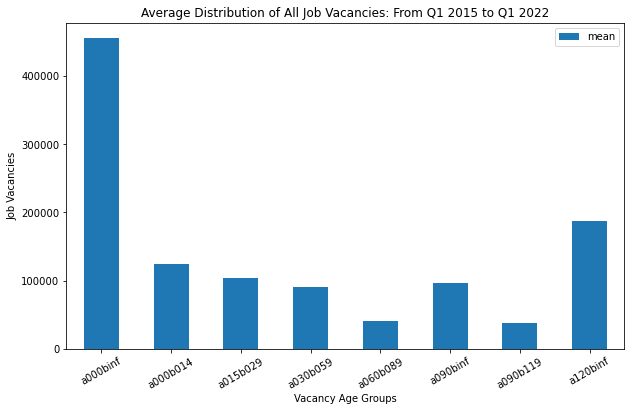

In [4]:
#Graph 3.1
df_all.describe().loc[['mean']].iloc[:, 4:].T.plot(kind="bar")
plt.xticks(rotation=30, horizontalalignment="center")
plt.xlabel("Vacancy Age Groups")
plt.ylabel("Job Vacancies")
plt.title("Average Distribution of All Job Vacancies: From Q1 2015 to Q1 2022")

plt.savefig('image/graph3-1.png', dpi=300)
plt.show()

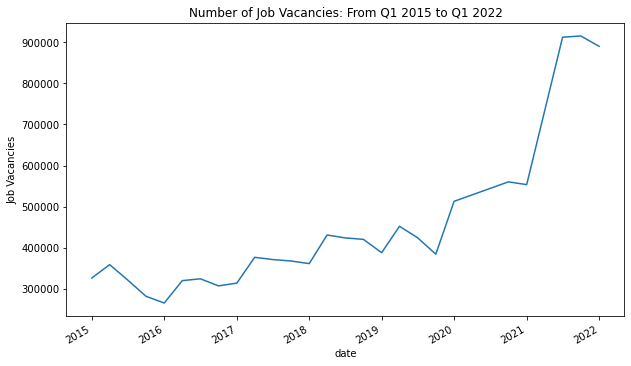

In [5]:
#Graph 3.2
df_all_1 = date(df_all)
df_all_1 = df_all_1.set_index(['date'])
df_all_1['a000binf'].plot()
plt.xlabel("date")
plt.ylabel("Job Vacancies")
plt.title("Number of Job Vacancies: From Q1 2015 to Q1 2022")

plt.savefig('image/graph3-2.png', dpi=300)
plt.show()

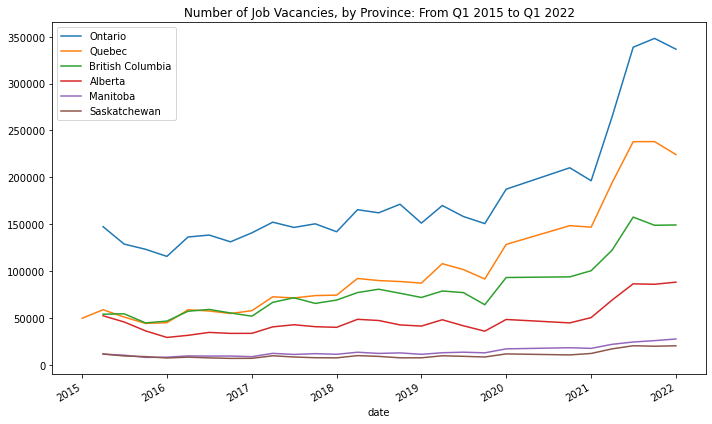

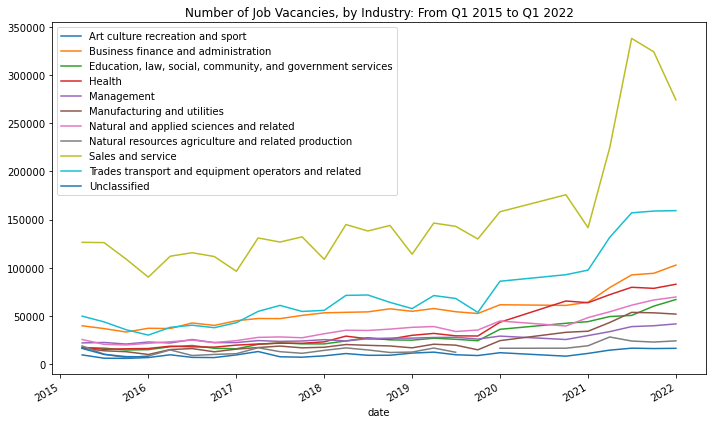

In [6]:
#Graph 3.3
#Graph 3.4
POV_stat = date(df_all).set_index(['date'])[['a000binf']].copy()
POV_stat = POV_stat.drop(columns=['a000binf'])
for i in POV_list:
    df = globals()[f'df_{i}']
    df = date(df).set_index(['date'])[['a000binf']]
    df.rename(columns = {'a000binf': i}, inplace = True)
    POV_stat = pd.merge(POV_stat, df, on = "date", how = "outer")
POV_stat.rename(columns = POVdict, inplace = True)
POV_stat.plot()
plt.title('Number of Job Vacancies, by Province: From Q1 2015 to Q1 2022')
plt.legend()

plt.tight_layout()
plt.savefig('image/graph3-3.png', dpi=300)
plt.show()


NOC_stat = date(df_all).set_index(['date'])[['a000binf']].copy()
NOC_stat = NOC_stat.drop(columns=['a000binf'])
for i in NOC_list:
    df = globals()[f'df_{i}']
    df = date(df).set_index(['date'])[['a000binf']]
    df.rename(columns = {'a000binf': i}, inplace = True)
    NOC_stat = pd.merge(NOC_stat, df, on = "date", how = "outer")
NOC_stat.rename(columns = NOCdict, inplace = True)
NOC_stat.plot()
plt.title('Number of Job Vacancies, by Industry: From Q1 2015 to Q1 2022')
plt.legend()

plt.tight_layout()
plt.savefig('image/graph3-4.png', dpi=300)
plt.show()

# MODEL & FITTING

Employing the steady-state assumption, we can model job vacancies over time as:
$$
v(t)=V_0(1-q)^t
$$
where $V_0$ is the inflow of new job vacancies created at $t=0$, and $q$ is the probability of a vacancy being filled during period $t$. The geometric series of the model would be:
$$
V_{a,b}=\sum_{t=a}^{b}v(t) \\
V_{a,b}={V_0(1-q)^a\left(1-(1-q)^b\right)\over1-(1-q)}
$$

In [7]:
def fitting(df0):
    LMparams = Parameters()
    LMparams.add_many(('v0', 1000, True, 100, 1000000), 
                      ('q', 0, True, 0, 1))
    a = df0['a'].to_numpy()
    b = df0['b'].to_numpy()
    v = df0['V'].to_numpy()
    ab = [a, b]
    
    def fcn2minLMExpCosErrFunc(params, ab, v):
        #fitting    v0 = coeffs[0] = , q = 1 - coeffs[1]
        v0 = params['v0']
        q = params['q']
        a = ab[0]
        b = ab[1]
        zeroInf = v0 / (1 - (1-q))
        adj = ((1-q) ** a) * (1 - ((1-q) ** b))
        return ((zeroInf * adj)-v)
    
    LMFitmin = Minimizer(fcn2minLMExpCosErrFunc, LMparams, fcn_args=(ab, v))
    LMFitResult = LMFitmin.minimize(method='least_squares')
    return LMFitResult

## FITTING ONE

In [8]:
def genDF0_1(df, df0, quarter):
    #df0 = df0.append({'year' : df.loc[quarter, 'year'], 'quarter' : df.loc[quarter, 'quarter'],
                      #'V':df.loc[quarter,'a000binf'],'a':float(0),'b':np.inf,'id':'a000binf'},ignore_index=True)
    df0 = df0.append({'year' : df.loc[quarter, 'year'], 'quarter' : df.loc[quarter, 'quarter'],
                      'V':df.loc[quarter,'a000b014'],'a':float(0),'b':float(14), 'id':'a000b014'},ignore_index=True)
    df0 = df0.append({'year' : df.loc[quarter, 'year'], 'quarter' : df.loc[quarter, 'quarter'],
                      'V':df.loc[quarter,'a015b029'],'a':float(15),'b':float(29),'id':'a015b029'},ignore_index=True)
    df0 = df0.append({'year' : df.loc[quarter, 'year'], 'quarter' : df.loc[quarter, 'quarter'],
                      'V':df.loc[quarter,'a030b059'],'a':float(30),'b':float(59),'id':'a030b059'},ignore_index=True)
    df0 = df0.append({'year' : df.loc[quarter, 'year'], 'quarter' : df.loc[quarter, 'quarter'],
                      'V':df.loc[quarter,'a060b089'],'a':float(60),'b':float(89),'id':'a060b089'},ignore_index=True)
    df0 = df0.append({'year' : df.loc[quarter, 'year'], 'quarter' : df.loc[quarter, 'quarter'],
                      'V':df.loc[quarter,'a090binf'],'a':float(90),'b':np.inf,'id':'a090binf'},ignore_index=True)
    df0 = df0.append({'year' : df.loc[quarter, 'year'], 'quarter' : df.loc[quarter, 'quarter'],
                      'V':df.loc[quarter,'a090b119'],'a':float(90),'b':float(119),'id':'a090b119'},ignore_index=True)
    df0 = df0.append({'year' : df.loc[quarter, 'year'], 'quarter' : df.loc[quarter, 'quarter'],
                      'V':df.loc[quarter,'a120binf'],'a':float(120),'b':np.inf,'id':'a120binf'},ignore_index=True)
    df0 = df0[df0['V'].notna()]
    df0['V'] = df0['V'].astype(float, errors='ignore')
    return df0

In [9]:
def model1_all(df):
    df = df.copy()
    df0 = pd.DataFrame()
    for quarter in range(len(df)):
        df0 = genDF0_1(df, df0, quarter)
    #fitting    v0 = coeffs[0] = , q = 1 - coeffs[1]
    fit = fitting(df0) 
    #record
    v0 = fit.params.get('v0').value
    q = fit.params.get('q').value
    ε = pd.Series(fit.residual)
    bic = fit.bic
    aic = fit.aic
    df0['ε'] = ε.values
    df['ε_a000binf'] = np.nan
    df['ε_a000b014'] = np.nan
    df['ε_a015b029'] = np.nan
    df['ε_a030b059'] = np.nan
    df['ε_a060b089'] = np.nan
    df['ε_a090binf'] = np.nan
    df['ε_a090b119'] = np.nan
    df['ε_a120binf'] = np.nan
    for i in range(len(df0)):
        ε_value = df0.loc[i, 'ε']
        year = df0.loc[i, 'year']
        quarter = df0.loc[i, 'quarter']
        id_name = df0.loc[i, 'id']
        df[f'ε_{id_name}'][(df["year"] == year) & (df["quarter"] == quarter)] = ε_value
    df['v0'] = v0
    df['q'] = q
    df['bic'] = bic
    df['aic'] = aic
    return df, fit

In [10]:
def model1_yearly(df):
    df = df.copy()
    df0 = pd.DataFrame()
    for year in range(2015, 2022+1 ,1):
        dfYEAR = df[(df['year'] == year)].copy()
        dfYEAR.index = range(0,len(dfYEAR))
        try:
            fit = model1_all(dfYEAR)[0] #[0]: table, [1]:V0, [2]: q
            dfYEAR = fit
            df0 = df0.append(dfYEAR)
        except:
            pass
    return df0

In [11]:
def model1_quarterly(df):
    df = df.copy()
    for quarter in range(len(df)):
        df0 = pd.DataFrame()
        df0 = genDF0_1(df, df0, quarter)
        #fitting    v0 = coeffs[0] = , q = 1 - coeffs[1]
        if len(df0.index) >= 2:
            fit = fitting(df0) 
        #record
            v0 = fit.params.get('v0').value
            q = fit.params.get('q').value
            bic = fit.bic
            aic = fit.aic
            df.loc[quarter, 'v0'] = v0
            df.loc[quarter, 'q'] = q
            df.loc[quarter, 'bic'] = bic
            df.loc[quarter, 'aic'] = aic
            idList = df0['id'].tolist()
            for i in range(len(fit.residual)):
                df.loc[quarter, f'ε_{idList[i]}'] = fit.residual[i]
            df0 = df0.iloc[0:0] #clear df0
    return df

In [12]:
Model1_A_wStat = model1_all(df_all)
Model1_A = Model1_A_wStat[0]
Model1_Y = model1_yearly(df_all)
Model1_Q = model1_quarterly(df_all)

Model1_A.to_excel(r'appendix/AppendixI_A.xlsx', index = False)
Model1_Y.to_excel(r'appendix/AppendixI_Y.xlsx', index = False)
Model1_Q.to_excel(r'appendix/AppendixI_Q.xlsx', index = False)

Model1_A = date(Model1_A).set_index(['date'])
Model1_Y = date(Model1_Y).set_index(['date'])
Model1_Q = date(Model1_Q).set_index(['date'])

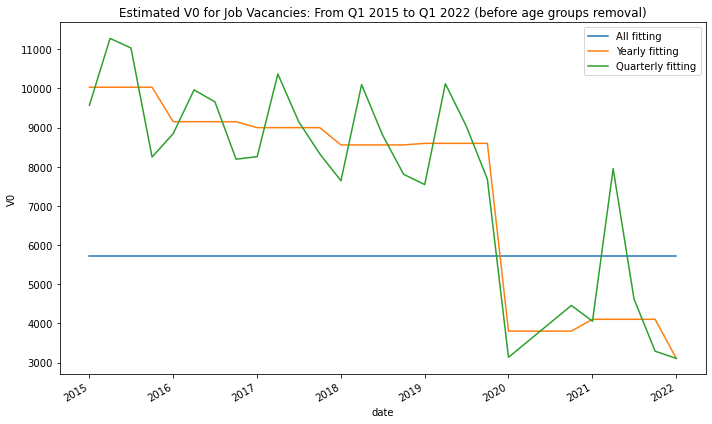

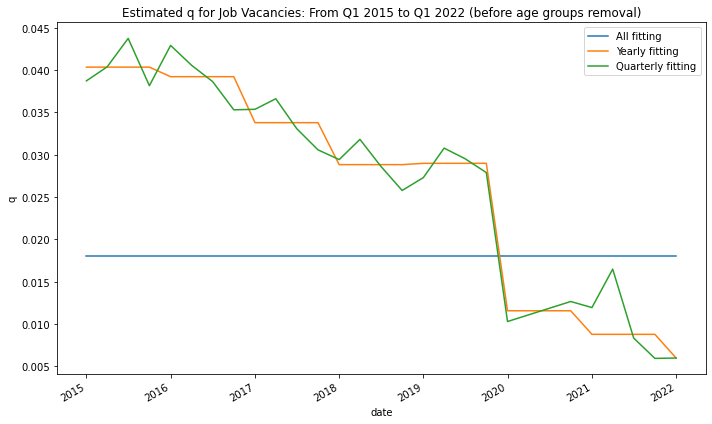

In [13]:
#Graph 5.1a
Model1_A['v0'].plot(label='All fitting')
Model1_Y['v0'].plot(label='Yearly fitting')
Model1_Q['v0'].plot(label='Quarterly fitting')
plt.legend()

plt.ylabel('V0')
plt.title('Estimated V0 for Job Vacancies: From Q1 2015 to Q1 2022 (before age groups removal)')

plt.tight_layout()
plt.savefig('image/graph5-1a.png', dpi=300)
plt.show()


#Graph 5.1b
Model1_A['q'].plot(label='All fitting')
Model1_Y['q'].plot(label='Yearly fitting')
Model1_Q['q'].plot(label='Quarterly fitting')
plt.legend()

plt.ylabel('q')
plt.title('Estimated q for Job Vacancies: From Q1 2015 to Q1 2022 (before age groups removal)')

plt.tight_layout()
plt.savefig('image/graph5-1b.png', dpi=300)
plt.show()

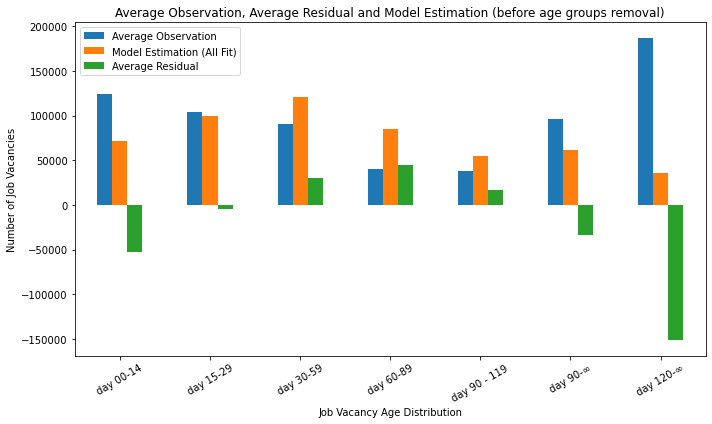

In [14]:
#graph5.1c
def graph5_1c(df):
    df = df.describe().loc[['mean']]
    df.index = range(0,len(df))
    index = ['day 00-14','day 15-29','day 30-59','day 60-89','day 90 - 119','day 90-∞','day 120-∞']
    
    obs = df[['a000b014','a015b029','a030b059','a060b089','a090b119','a090binf','a120binf']].T
    obs['Time Interval'] = index
    obs.rename(columns = {0: 'Average Observation'}, inplace = True)
    obs = obs.set_index('Time Interval')
    
    res = df[['ε_a000b014','ε_a015b029','ε_a030b059','ε_a060b089','ε_a090b119','ε_a090binf','ε_a120binf']].T
    res['Time Interval'] = index
    res.rename(columns = {0: 'Average Residual'}, inplace = True)
    res = res.set_index('Time Interval')
    
    df0 = pd.concat([obs, res], axis=1)    
    df0['Model Estimation (All Fit)'] = df0['Average Observation'] + df0['Average Residual']
    df0 = df0[['Average Observation', 'Model Estimation (All Fit)', 'Average Residual']]
    
    df0.plot(kind="bar")
    plt.xticks(rotation=30, horizontalalignment="center")
    plt.xlabel("Job Vacancy Age Distribution")
    plt.ylabel("Number of Job Vacancies")
    plt.title(f"Average Observation, Average Residual and Model Estimation (before age groups removal)")
    plt.savefig('image/graph5-1c.png', dpi=300, bbox_inches="tight")
    plt.tight_layout()
    plt.show()
    
graph5_1c(Model1_A)

In [15]:
Model1_A_wStat[1]

## FITTING TWO

In [16]:
def genDF0_2(df, df0, quarter):
    df0 = df0.append({'year' : df.loc[quarter, 'year'], 'quarter' : df.loc[quarter, 'quarter'],
                      'V':df.loc[quarter,'a000b014'],'a':float(0),'b':float(14), 'id':'a000b014'},ignore_index=True)
    df0 = df0.append({'year' : df.loc[quarter, 'year'], 'quarter' : df.loc[quarter, 'quarter'],
                      'V':df.loc[quarter,'a015b029'],'a':float(15),'b':float(29),'id':'a015b029'},ignore_index=True)
    df0 = df0.append({'year' : df.loc[quarter, 'year'], 'quarter' : df.loc[quarter, 'quarter'],
                      'V':df.loc[quarter,'a030b059'],'a':float(30),'b':float(59),'id':'a030b059'},ignore_index=True)
    df0 = df0.append({'year' : df.loc[quarter, 'year'], 'quarter' : df.loc[quarter, 'quarter'],
                      'V':df.loc[quarter,'a060b089'],'a':float(60),'b':float(89),'id':'a060b089'},ignore_index=True)
    try:
        df0 = df0.append({'year' : df.loc[quarter, 'year'], 'quarter' : df.loc[quarter, 'quarter'],
                          'V':df.loc[quarter,'a090b119'],'a':float(60),'b':float(89),'id':'a090b119'},ignore_index=True)
    except:
        pass
    df0 = df0[df0['V'].notna()]
    df0['V'] = df0['V'].astype(float, errors='ignore')
    return df0

In [17]:
def model2_all(df):
    df = df.copy()
    df0 = pd.DataFrame()
    for quarter in range(len(df)):
        df0 = genDF0_2(df, df0, quarter)
    #fitting    v0 = coeffs[0] = , q = 1 - coeffs[1]
    fit = fitting(df0) 
    #record
    v0 = fit.params.get('v0').value
    q = fit.params.get('q').value
    ε = pd.Series(fit.residual)
    bic = fit.bic
    aic = fit.aic
    df0['ε'] = ε.values
    df['ε_a000b014'] = np.nan
    df['ε_a015b029'] = np.nan
    df['ε_a030b059'] = np.nan
    df['ε_a060b089'] = np.nan
    df['ε_a090b119'] = np.nan
    for i in range(len(df0)):
        ε_value = df0.loc[i, 'ε']
        year = df0.loc[i, 'year']
        quarter = df0.loc[i, 'quarter']
        id_name = df0.loc[i, 'id']
        df[f'ε_{id_name}'][(df["year"] == year) & (df["quarter"] == quarter)] = ε_value
    if q >=0.0001:
        if v0 >= 101:
            df['v0'] = v0
            df['q'] = q
            df['bic'] = bic
            df['aic'] = aic
    return df, fit

In [18]:
def model2_yearly(df):
    df = df.copy()
    df0 = pd.DataFrame()
    for year in range(2015, 2022+1 ,1):
        dfYEAR = df[(df['year'] == year)].copy()
        dfYEAR.index = range(0,len(dfYEAR))
        try:
            fit = model2_all(dfYEAR)[0] #[0]: table, [1]:fit
            dfYEAR = fit
            df0 = df0.append(dfYEAR)
        except:
            pass
    return df0

In [19]:
def model2_quarterly(df):
    df = df.copy()
    for quarter in range(len(df)):
        df0 = pd.DataFrame()
        df0 = genDF0_2(df, df0, quarter)
        #fitting    v0 = coeffs[0] = , q = 1 - coeffs[1]
        if len(df0.index) >= 2:
            fit = fitting(df0) 
        #record
            v0 = fit.params.get('v0').value
            q = fit.params.get('q').value
            bic = fit.bic
            aic = fit.aic
            df.loc[quarter, 'v0'] = v0
            df.loc[quarter, 'q'] = q
            df.loc[quarter, 'bic'] = bic
            df.loc[quarter, 'aic'] = aic
            idList = df0['id'].tolist()
            for i in range(len(fit.residual)):
                df.loc[quarter, f'ε_{idList[i]}'] = fit.residual[i]
    return df

In [20]:
Model2_A_wStat = model2_all(df_all)
Model2_A = model2_all(df_all)[0]
Model2_Y = model2_yearly(df_all)
Model2_Q = model2_quarterly(df_all)

Model2_A.to_excel(r'appendix/AppendixII_A.xlsx', index = False)
Model2_Y.to_excel(r'appendix/AppendixII_Y.xlsx', index = False)
Model2_Q.to_excel(r'appendix/AppendixII_Q.xlsx', index = False)

Model2_A = date(Model2_A).set_index(['date'])
Model2_Y = date(Model2_Y).set_index(['date'])
Model2_Q = date(Model2_Q).set_index(['date'])

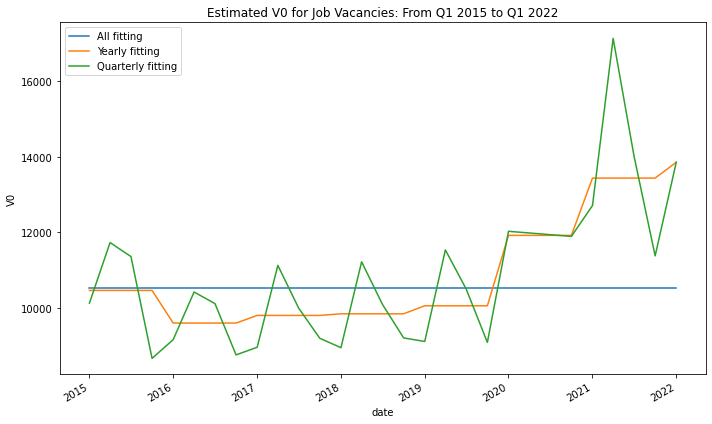

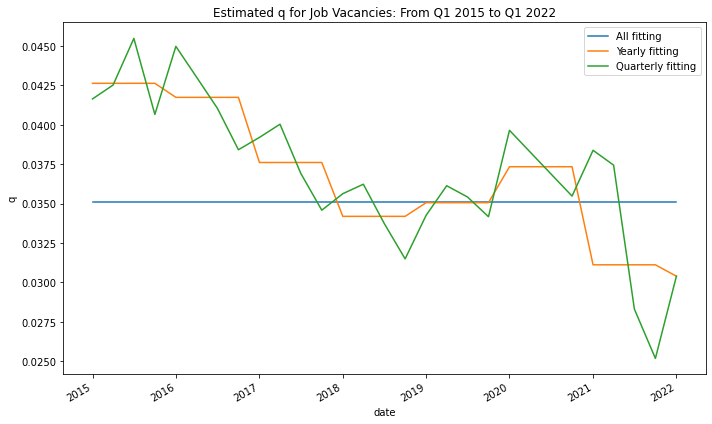

In [21]:
# Graph 5.2a
Model2_A['v0'].plot(label='All fitting')
Model2_Y['v0'].plot(label='Yearly fitting')
Model2_Q['v0'].plot(label='Quarterly fitting')
plt.legend()

plt.ylabel('V0')
plt.title('Estimated V0 for Job Vacancies: From Q1 2015 to Q1 2022')
plt.tight_layout()
plt.savefig('image/graph5-2a.png', dpi=300)
plt.show()

#Graph 5.2b
Model2_A['q'].plot(label='All fitting')
Model2_Y['q'].plot(label='Yearly fitting')
Model2_Q['q'].plot(label='Quarterly fitting')
plt.legend()

plt.ylabel('q')
plt.title('Estimated q for Job Vacancies: From Q1 2015 to Q1 2022')

plt.tight_layout()
plt.savefig('image/graph5-2b.png', dpi=300)
plt.show()

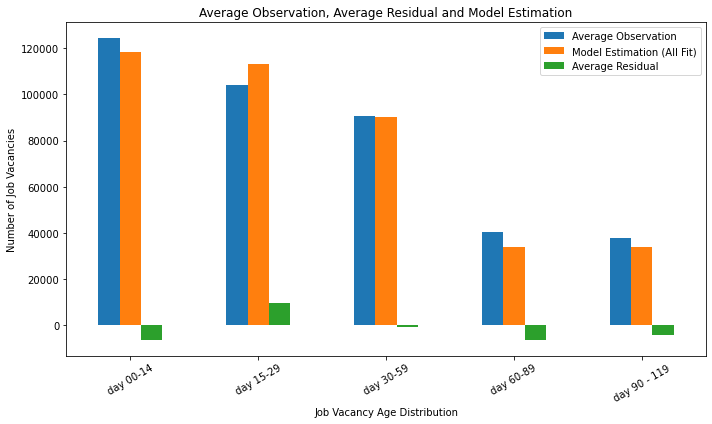

In [22]:
#graph5.2c
def graph5_2c(df):
    df = df.describe().loc[['mean']]
    df.index = range(0,len(df))
    index = ['day 00-14','day 15-29','day 30-59','day 60-89','day 90 - 119']
    
    obs = df[['a000b014','a015b029','a030b059','a060b089','a090b119']].T
    obs['Time Interval'] = index
    obs.rename(columns = {0: 'Average Observation'}, inplace = True)
    obs = obs.set_index('Time Interval')
    
    res = df[['ε_a000b014','ε_a015b029','ε_a030b059','ε_a060b089','ε_a090b119']].T
    res['Time Interval'] = index
    res.rename(columns = {0: 'Average Residual'}, inplace = True)
    res = res.set_index('Time Interval')
    
    df0 = pd.concat([obs, res], axis=1)    
    df0['Model Estimation (All Fit)'] = df0['Average Observation'] + df0['Average Residual']
    df0 = df0[['Average Observation', 'Model Estimation (All Fit)', 'Average Residual']]
    
    df0.plot(kind="bar")
    plt.xticks(rotation=30, horizontalalignment="center")
    plt.xlabel("Job Vacancy Age Distribution")
    plt.ylabel("Number of Job Vacancies")
    plt.title(f"Average Observation, Average Residual and Model Estimation")
    plt.savefig('image/graph5-2c.png', dpi=300, bbox_inches="tight")
    plt.tight_layout()
    plt.show()
    
graph5_2c(Model2_A)

In [23]:
Model2_A_wStat[1]

# Homogeneity

In [24]:
for i in VacancyCharacteristics:
    df = globals()[f'df_{i}']
    globals()[f'model2_{i}'] = model2_yearly(df)

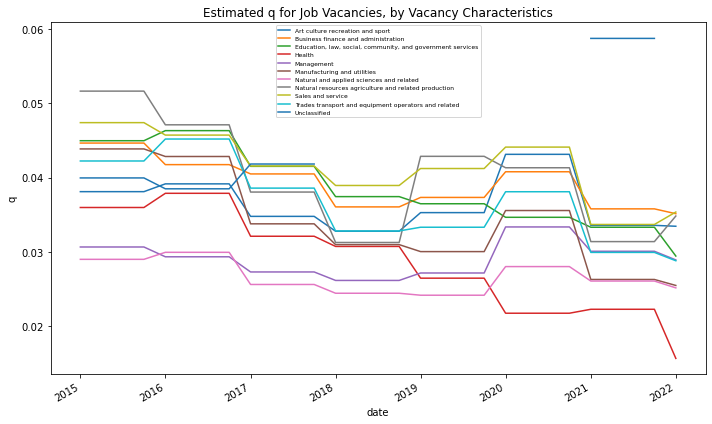

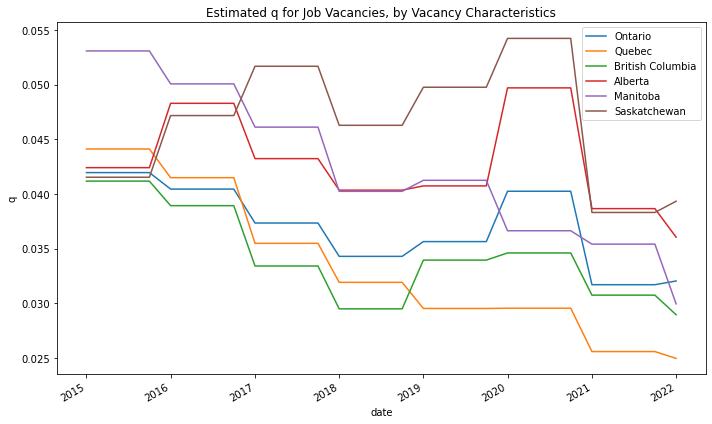

In [25]:
#Graphs 5.3a
plot_year_all = Model2_Y[['q']]
plot_year_all = plot_year_all.rename({'q': 'q_All'}, axis='columns')
#q NOC
plot_year = pd.DataFrame()
plot_year = plot_year.append(plot_year_all)
for i in NOC_list:
    df = globals()[f'model2_{i}']
    df = date(df).set_index(['date'])
    df = df[['q']]
    df = df.rename({'q': f'q_{i}'}, axis='columns')
    plot_year =pd.merge(plot_year, df, on = "date", how = "outer")
plot_year = plot_year.drop(columns=['q_All'])
plot_year.rename(columns = q_NOCdict, inplace = True)
plot_year.plot()
plt.title('Estimated q for Job Vacancies, by Vacancy Characteristics')
plt.legend(prop={'size': 6})

plt.ylabel('q')
plt.tight_layout()
plt.savefig('image/graph5-3a.png', dpi=300)
plt.show()

#Graphs 5.3b
#q POV
plot_year = pd.DataFrame()
plot_year = plot_year.append(plot_year_all)
for i in POV_list:
    df = globals()[f'model2_{i}']
    df = date(df).set_index(['date'])
    df = df[['q']]
    df = df.rename({'q': f'q_{i}'}, axis='columns')
    plot_year =pd.merge(plot_year, df, on = "date", how = "outer")
plot_year = plot_year.drop(columns=['q_All'])
plot_year.rename(columns = q_POVdict, inplace = True)
plot_year.plot()
plt.title('Estimated q for Job Vacancies, by Vacancy Characteristics')
plt.legend()

plt.ylabel('q')
plt.tight_layout()
plt.savefig('image/graph5-3b.png', dpi=300)
plt.show()

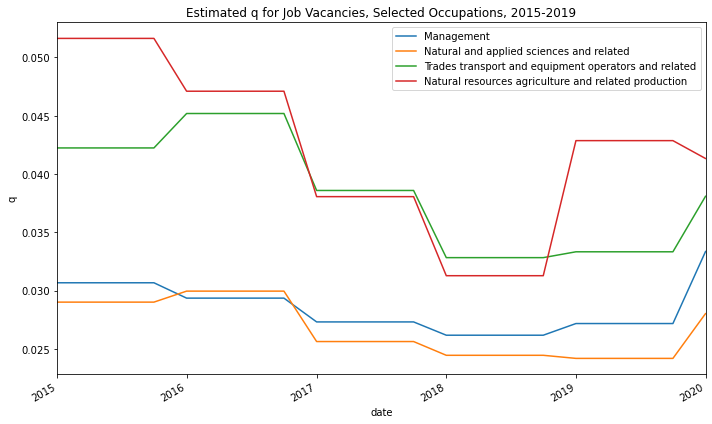

In [26]:
#Graph 5.3c
select_manage = date(model2_manage).copy().set_index(['date'])
select_engine = date(model2_engine).copy().set_index(['date'])
select_trades = date(model2_trades).copy().set_index(['date'])
select_agricu = date(model2_agricu).copy().set_index(['date'])

select_manage['q'].plot(label='Management').set_xlim([datetime.date(2015, 1, 1), datetime.date(2020, 1, 1)])
select_engine['q'].plot(label='Natural and applied sciences and related').set_xlim([datetime.date(2015, 1, 1), datetime.date(2020, 1, 1)])
select_trades['q'].plot(label='Trades transport and equipment operators and related').set_xlim([datetime.date(2015, 1, 1), datetime.date(2020, 1, 1)])
select_agricu['q'].plot(label='Natural resources agriculture and related production').set_xlim([datetime.date(2015, 1, 1), datetime.date(2020, 1, 1)])

plt.title('Estimated q for Job Vacancies, Selected Occupations, 2015-2019')

plt.legend()
plt.ylabel('q')
plt.tight_layout()
plt.savefig('image/graph5-3c.png', dpi=300)
plt.show()